# Investigate a Dataset - [IMDB - Movies]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> What can we say about the success of a movie before it is released? Are there certain companies (Pixar?) that have found a consistent formula? Given that major films costing over $100 million to produce can still flop, this question is more important than ever to the industry. Film aficionados might have different interests. Can we predict which films will be highly rated, whether or not they are a commercial success?

This is a great place to start digging in to those questions, with data on the plot, cast, crew, budget, and revenues of several thousand films.

### Question(s) for Analysis
>Are the budgets and revenues correlated? Do they consistently show the global popularity?<br>
Are some cast members or directors correlated to better reviews or rating?<br>
Or maybe genres define popularity more?<br>
All these are good question and will try to check for more during the process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep
from tqdm.notebook import tqdm
import sys

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> Let's load the data and check for cleanliness.

In [2]:
df = pd.read_csv('tmdb-movies.csv')

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

From this Summary we can get some insights and cleanliness issues too

##### Insights:
> 1. There is a correlation between these columns: [budget, revenue, popularity, vote_count]<br>
2. Popularity is mostly bound between 0.2 and 0.7 with outliers in both sides we still unsure what this metric means and hence further search is advised. <br>
3. Because of a lot of zeros in [budget, revenue] we can't know the distribution for now.<br>
4. Some movies have the same name so we need to leave IMDB id as is for differentiating.<br>
5. Movie runtime is mostly bound between 90 minutes and 111 with some extreme cases in both directions. <br>
6. Seems like the reviews are not audience reviews since the count is so low are the review counts range from 17 and 145 on average.<br>
7. The average votes is definitely normally distributed
8. Vote_counts play a huger role than vote_average which is remarkable of how movies that are popular are not the ones that must be critically acclaimed.<br><br>
##### Cleanliness:
>1. 13434 missing cells along with more than 12000 zero values, these needs to be scraped or sadly dropped.<br>
2. No duplicates which is good.<br>
3. These columns have missing values [tag-line, keywords,production,IMDB_id]<br>
4. And these are mostly zeros sadly [budget, revenue, budget_adj, revenue_adj]<br>
5. A lot of outliers in most numerical columns.<br>
6. Some multi-variables needs to be broken when needed (they are separated by a " | ")

In [4]:
clean = df.copy() #Making a copy of the df as a back up and for comparisons

In [5]:
df.columns[df.isnull().any()]

Index(['imdb_id', 'cast', 'homepage', 'director', 'tagline', 'keywords',
       'overview', 'genres', 'production_companies'],
      dtype='object')

We can see here the columns with null values.

In [6]:
df.describe()

id    popularity        budget       revenue       runtime  \
count   10866.000000  10866.000000  1.086600e+04  1.086600e+04  10866.000000   
mean    66064.177434      0.646441  1.462570e+07  3.982332e+07    102.070863   
std     92130.136561      1.000185  3.091321e+07  1.170035e+08     31.381405   
min         5.000000      0.000065  0.000000e+00  0.000000e+00      0.000000   
25%     10596.250000      0.207583  0.000000e+00  0.000000e+00     90.000000   
50%     20669.000000      0.383856  0.000000e+00  0.000000e+00     99.000000   
75%     75610.000000      0.713817  1.500000e+07  2.400000e+07    111.000000   
max    417859.000000     32.985763  4.250000e+08  2.781506e+09    900.000000   

         vote_count  vote_average  release_year    budget_adj   revenue_adj  
count  10866.000000  10866.000000  10866.000000  1.086600e+04  1.086600e+04  
mean     217.389748      5.974922   2001.322658  1.755104e+07  5.136436e+07  
std      575.619058      0.935142     12.812941  3.430616e+07  1.446325e+08  
min       10.000000      1.500000   1960.000000  0.000000e+00  0.000000e+00  
25%       17.000000      5.400000   1995.000000  0.000000e+00  0.000000e+00  
50%       38.000000      6.000000   2006.000000  0.000000e+00  0.000000e+00  
75%      145.750000      6.600000   2011.000000  2.085325e+07  3.369710e+07  
max     9767.000000      9.200000   2015.000000  4.250000e+08  2.827124e+09

In [7]:
df[df.cast.isnull()].head(3)

id    imdb_id  popularity  budget  revenue  \
371  345637  tt4661600    0.422901       0        0   
441  355020  tt4908644    0.220751       0        0   
465  321109  tt4393514    0.201696       0        0   

                                  original_title cast  \
371                          Sanjay's Super Team  NaN   
441  Winter on Fire: Ukraine's Fight for Freedom  NaN   
465                                  Bitter Lake  NaN   

                                  homepage           director  \
371                                    NaN       Sanjay Patel   
441  http://www.netflix.com/title/80031666  Evgeny Afineevsky   
465                                    NaN        Adam Curtis   

                               tagline  ...  \
371                                NaN  ...   
441  The Next Generation Of Revolution  ...   
465                                NaN  ...   

                                              overview runtime       genres  \
371  Sanjay's Super Team follows the daydream of a ...       7    Animation   
441  A documentary on the unrest in Ukraine during ...      98  Documentary   
465  An experimental documentary that explores Saud...     135  Documentary   

                                  production_companies release_date  \
371                            Pixar Animation Studios     11/25/15   
441  Passion Pictures|Campbell Grobman Films|Afinee...      10/9/15   
465                                                BBC      1/24/15   

    vote_count  vote_average  release_year  budget_adj  revenue_adj  
371         47           6.9          2015         0.0          0.0  
441         37           8.2          2015         0.0          0.0  
465         19           7.8          2015         0.0          0.0  

[3 rows x 21 columns]

In [8]:
def Fetch_cast(df, column, tag, variable, value, many):
    '''
    Scrape cast data from imdb and apply in a dataframe
    
    Arguments:
        df: pandas dataframe we wish to get the imdb id from
        column: str choose a column between ['cast', 'director']
        tag: str the html tag that contains the cast/director
        variable: str an attribute inside the tag
        variablealue: str the value of the attribute
        many: int max number of cast members/directors needed to scrape
        
    Returns:
        void
    '''
    nulls = 0
    filled = 0
    with tqdm(total=df.shape[0], ) as pbar: #to check how far we have reached
        for index, movie in df.iterrows():
            pbar.update(1)
            if pd.isnull(movie[column]): #we only want to iterate on missing values
                nulls = nulls + 1 
                if not pd.isnull(movie['imdb_id']): #since some of the records lacks an imdb id so this will make sure we skip
                    try:
                        string = ''
                        html = requests.get('https://www.imdb.com/title/' + movie['imdb_id'])
                        soup = BeautifulSoup(html.content, 'html.parser')
                        query = soup.find_all(tag, {variable: value})
                        for i in range(len(query)): #if the query returned more than one output
                            if i < many: #but we already specified the max number needed
                                string += query[i].contents[0] + '|'
                        if string == '':
                            continue
                        else:
                            clean.at[index, column] = string[:-1] #applying the new data
                            filled = filled + 1
                    except Exception as e:
                        continue
                update = "Nulls Found: {}      Nulls Filled: {}".format(nulls, filled)
                sys.stdout.write("\r" + update)
                sys.stdout.flush()

            else:
                continue

I have made the next two codeblocks commented since each takes aound 4 mins to run

In [9]:
#Fetch_cast(clean, 'cast', 'a', 'data-testid', 'title-cast-item__actor', 3)

In [10]:
#Fetch_cast(clean, 'director', 'a', 'class', 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link', 1)

In [11]:
def fetch_genres(df):
    
    '''
    Scrape genre data from imdb and apply in a dataframe
    
    Arguments:
        df: pandas dataframe we wish to get the imdb id from
        
    Returns:
        void
    '''
    
    nulls = 0
    filled = 0

    with tqdm(total=df.shape[0], ) as pbar: #to check how far we have reached
        for index, movie in df.iterrows():
            pbar.update(1)
            if pd.isnull(movie['genres']): #we only want to iterate on missing values
                nulls = nulls + 1
                if not pd.isnull(movie['imdb_id']): #since some of the records lacks an imdb id so this will make sure we skip
                    try:
                        string = ''
                        html = requests.get('https://www.imdb.com/title/' + movie['imdb_id'])
                        soup = BeautifulSoup(html.content, 'html.parser')
                        query = soup.find_all('a', {'class': 'sc-16ede01-3 bYNgQ ipc-chip ipc-chip--on-baseAlt'})
                        for i in range(len(query)): #if the query returned more than one output
                            if i < 3: #but we already specified the max number needed
                                string += query[i].contents[0].contents[0].contents[0] + '|'
                        if string == '':
                            continue
                        else:
                            clean.at[index, 'genres'] = string[:-1] #applying the new data
                            filled = filled + 1
                    except Exception as e:
                        continue
                update = "Nulls Found: {}      Nulls Filled: {}".format(nulls, filled)
                sys.stdout.write("\r" + update)
                sys.stdout.flush()

            else:
                continue

This takes only 30 secs 

In [12]:
#fetch_genres(clean)

In [13]:
'''from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all'''

'from IPython.core.interactiveshell import InteractiveShell\nInteractiveShell.ast_node_interactivity = "all'

In [14]:
'cast', df.cast.isnull().sum(), clean.cast.isnull().sum()

('cast', 76, 76)

In [15]:
'director', df.director.isnull().sum(), clean.director.isnull().sum()

('director', 44, 44)

In [16]:
'genres', df.genres.isnull().sum(), clean.genres.isnull().sum()

('genres', 23, 23)

Only run the next cell if you ran all of the above code to its end

In [17]:
#clean.to_csv('clean.csv', index=False)

In [18]:
clean.genres.isnull().sum()

23

In [19]:
def fetch_rev(df):
    '''
    Scrape revenue data from imdb and apply in a dataframe
    
    Arguments:
        df: pandas dataframe we wish to get the imdb id from
        
    Returns:
        void
    '''
        
    nulls = 0
    filled = 0

    with tqdm(total=df.shape[0], ) as pbar: #to check how far we have reached
        for index, movie in df.iterrows(): 
            pbar.update(1)
            nulls = nulls + 1
            if not pd.isnull(movie['imdb_id']): #since some of the records lacks an imdb id so this will make sure we skip
                try:
                    html = requests.get('https://www.imdb.com/title/' + movie['imdb_id'])
                    soup = BeautifulSoup(html.content, 'html.parser')
                    query = soup.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'})
                    child1 = query.find_all('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                    string = child1[0].contents[0][1:]
                    string = string.replace(',', '')

                    if string == '':
                        continue
                    else:
                        clean.at[index, 'revenue'] = string #applying the new data
                        filled = filled + 1
                except Exception as e:
                    print(e)
                    continue
            update = "Nulls Found: {}      Nulls Filled: {}".format(nulls, filled)
            sys.stdout.write("\r" + update)
            sys.stdout.flush()

# IT IS REALLY ADVICED NOT TO RUN THIS CELL SINCE IT TAKES AROUND 6 HRS TO FINISH

In [20]:
#fetch_rev(df)

In [21]:
cleaned1 = abs((clean.revenue == 0).sum() - (df.revenue == 0).sum())

In [22]:
inf = pd.read_csv('infrate.csv')
inf.rename(columns={'Year': 'release_year', 'Value': 'inflation'},inplace = True)
inf.head(2)

release_year  inflation
0          1958   9.888625
1          1959   9.789683

Only run the cells bellow if you ran the above function

In [23]:
#clean2 = pd.merge(clean2, inf, on='release_year',how='left')

In [24]:
#clean2.revenue_adj = clean2.revenue * clean2['inflation']

In [25]:
#clean2.to_csv('clean2.csv', index=False)

In [26]:
def fetch_budget(df):
    '''
    Scrape budget data from imdb and apply in a dataframe
    
    Arguments:
        df: pandas dataframe we wish to get the imdb id from
        
    Returns:
        void
    '''
    nulls = 0
    filled = 0

    with tqdm(total=df.shape[0], ) as pbar: #to check how far we have reached
        for index, movie in df.iterrows():
            pbar.update(1)
            nulls = nulls + 1
            if not pd.isnull(movie['imdb_id']): #since some of the records lacks an imdb id so this will make sure we skip
                try:
                    html = requests.get('https://www.imdb.com/title/' + movie['imdb_id'])
                    soup = BeautifulSoup(html.content, 'html.parser')
                    query = soup.find('li', {'data-testid': 'title-boxoffice-budget'})
                    child1 = query.find_all('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                    string = child1[0].contents[0].strip(' (estimated)')[1:]
                    string = string.replace(',', '')
                    if string == '':
                        continue
                    else:
                        clean2.at[index, 'budget'] = string #applying the new data
                        filled = filled + 1
                except Exception as e:
                    continue
            update = "Nulls Found: {}      Nulls Filled: {}".format(nulls, filled)
            sys.stdout.write("\r" + update)
            sys.stdout.flush()

# IT IS REALLY ADVICED NOT TO RUN THIS CELL SINCE IT TAKES AROUND 6 HRS TO FINISH

In [27]:
#fetch_budget(df)

In [28]:
#cleaned2 = abs((clean2.budget == 0).sum() - (df.budget == 0).sum())

In [29]:
#cleaned1 + cleaned2 

## We have filled 5070 cells which is really great.

In [30]:
#clean2.budget = clean2.budget * clean2['inflation']

In [31]:
#clean2.to_csv('clean2.csv', index=False)

In [32]:
clean2 = pd.read_csv('clean2.csv')

In [33]:
final = pd.read_csv('Final.csv')
final.columns

Index(['imdb_id', 'popularity', 'original_title', 'cast', 'director',
       'tagline', 'keywords', 'overview', 'runtime', 'genres',
       'production_companies', 'release_date', 'vote_count', 'vote_average',
       'release_year', 'budget_adj', 'revenue_adj', 'inflation'],
      dtype='object')

In [34]:
final['budget_adj'] = clean2.budget * clean2['inflation']

In [35]:
final.to_csv('final.csv', index=False)

The only Cleanliness issue now is multivalued columns but we will split them when needed

<a id='eda'></a>
## Exploratory Data Analysis
> Phew that was a lot to take in, let's hop back in some viz

In [36]:
profile = ProfileReport(final, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
from scipy import stats

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.6, .9), xycoords=ax.transAxes)

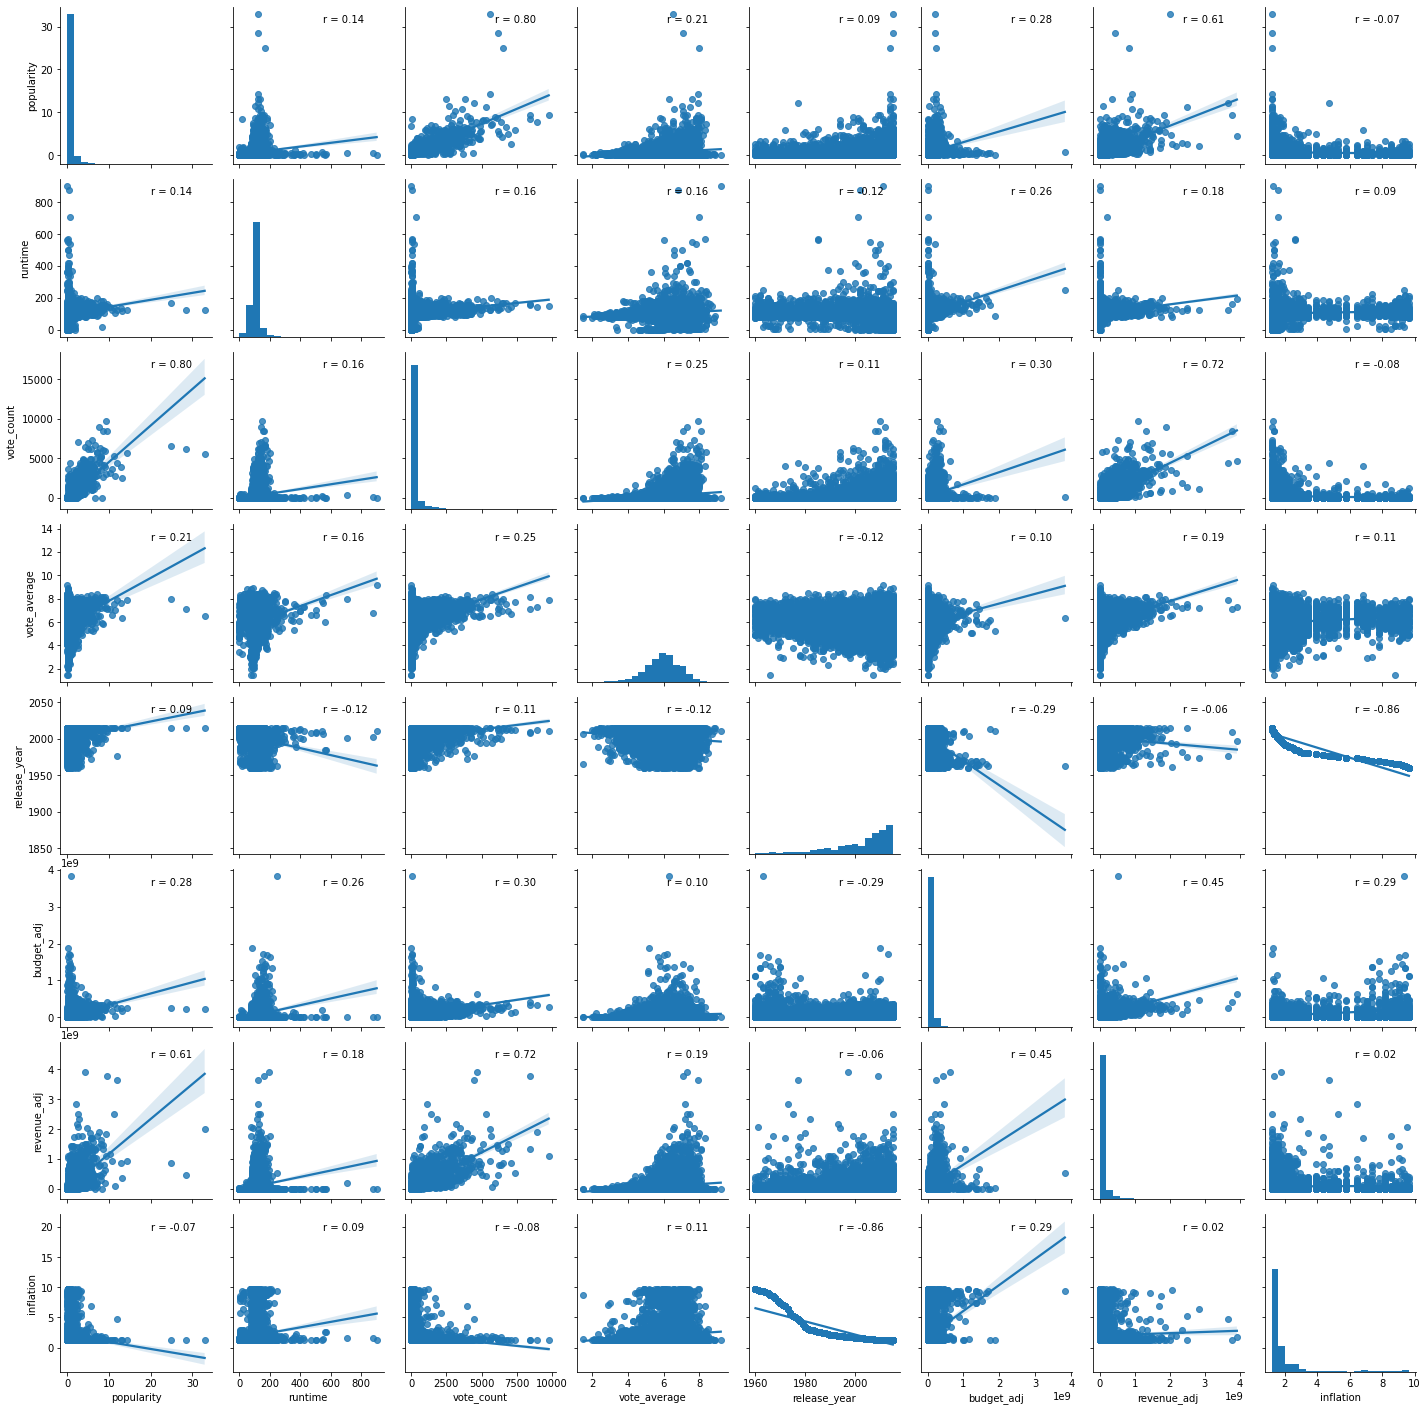

In [38]:
import seaborn as sns
g = sns.PairGrid(data = final);
g.map_diag(plt.hist, bins = 20);
g.map_offdiag(sns.regplot);
g.map_offdiag(corrfunc)

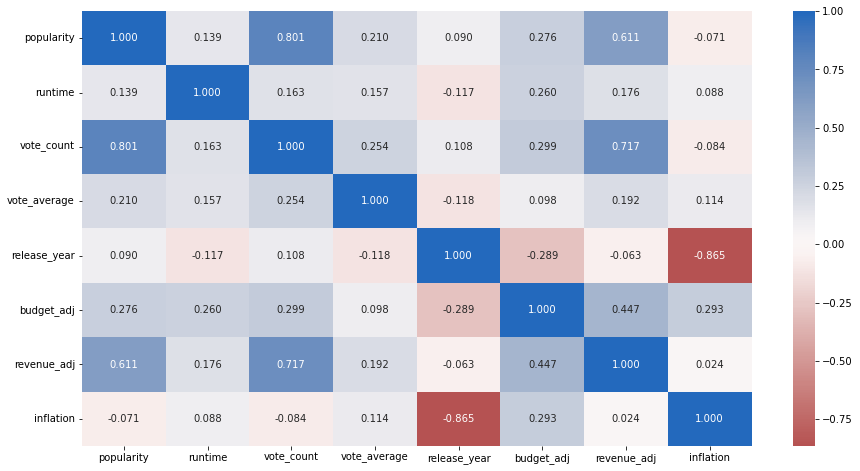

In [39]:
plt.figure(figsize = [15, 8])
sns.heatmap(final.select_dtypes(include=np.number).corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0);

Magnifying the previous charts and looking we can find a lot actually:
> 1. The more popular the movie is the more votes it might get "expected" and more revenue too "expected"
> 2. The higher the vote counts, the higher the average might be.
> 3. The higher times a movie is rated the higher the revenue might gross, however vote average doesn't have such a strong corr and thus we deduce a high grossing movie is a popular movie but that doesn't mean that it's critically acclaimed.
> 4. This will sound good for producers, the more budget you put in the more you revenue.

The above graphs says a lot but let's dive in a bit deeper

###### Those answers some of our questions earlier, but here comes feature engineering where we will study individual cast members, directors, genres and more

> Now let's see if individual directors have an effect.

In [40]:
final.columns

Index(['imdb_id', 'popularity', 'original_title', 'cast', 'director',
       'tagline', 'keywords', 'overview', 'runtime', 'genres',
       'production_companies', 'release_date', 'vote_count', 'vote_average',
       'release_year', 'budget_adj', 'revenue_adj', 'inflation'],
      dtype='object')

In [41]:
def subdf(column, leftquant, rightquant):
    '''
    Makes a grouped datafram on column specified and calculates it's standard deviation after removing outliers
    for each group and plots heatmaps for all features
    
    Arguments:
        column: string that contains name of column
        leftquant: int bet(0-1) of the percentage of removing from left hand side outliers
        rightquant: int bet(0-1) of the percentage of removing from right hand side outliers
        
    Returns:
        void
    '''
    dfs = final[[column, 'popularity', 'budget_adj', 'revenue_adj', 'vote_count', 'vote_average']]
    dfs = dfs[dfs[column].notna()]
    dfs[column] = dfs[column].str.replace('|',',',regex=False).str.strip()
    dfs[column] = dfs[column].str.split(',').tolist()
    dfs = dfs.explode(column,ignore_index=True)
    dfsm = dfs.groupby(column).mean()
    dfsms = dfs.groupby(column).mean()
    
    for i in ['popularity', 'budget_adj', 'revenue_adj', 'vote_count', 'vote_average']:
        pl = dfsms[i].quantile(leftquant)
        pr = dfsms[i].quantile(rightquant)
        dfsms = dfsms[dfsms[i].gt(pl) & dfsms[i].lt(pr)]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)

    sns.heatmap(dfsm.select_dtypes(include=np.number).corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0,ax=ax1);

    sns.heatmap(final[['popularity', 'budget_adj', 'revenue_adj', 'vote_count', 'vote_average']].select_dtypes(include=np.number).corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0,ax=ax2);
    
    sns.heatmap(dfsms.select_dtypes(include=np.number).corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0,ax=ax3);
    

    fig.set_figheight(7.5);
    fig.set_figwidth(30);
    ax1.set_title('Grouped by {}'.format(column));
    ax2.set_title('Normal');
    ax3.set_title('Grouped by {}, outliers removed'.format(column));

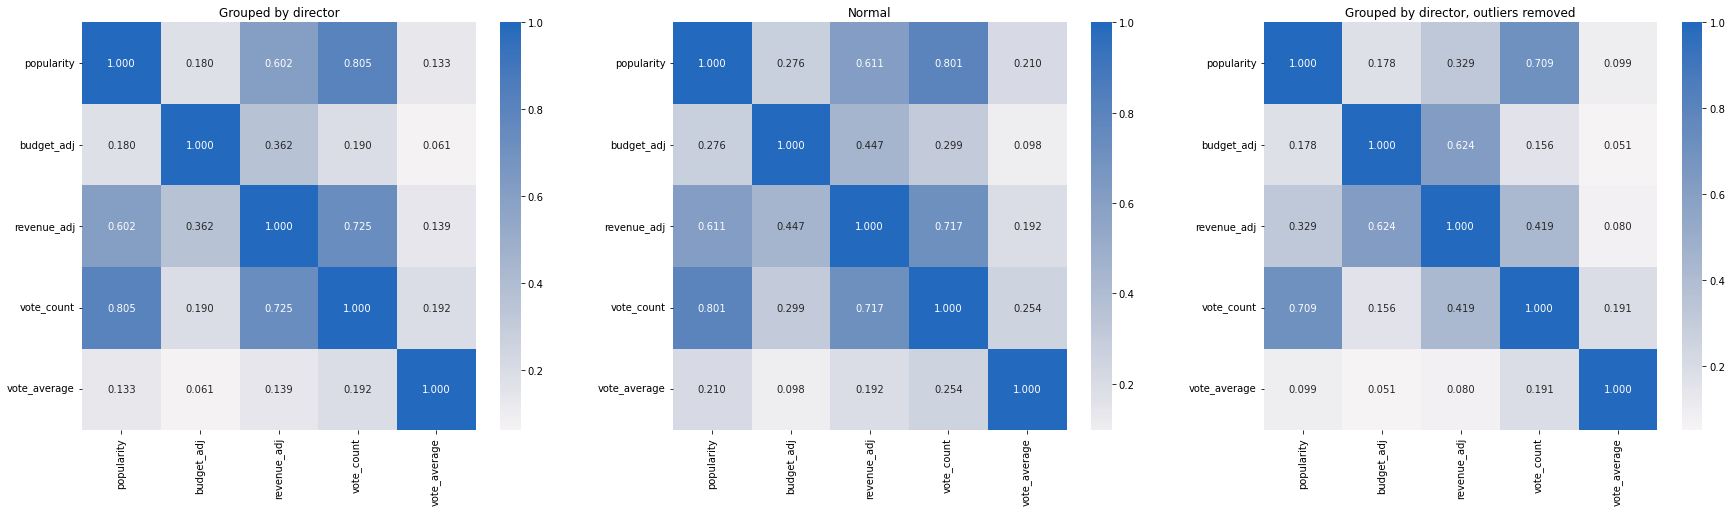

In [42]:
subdf('director',0.05,0.95)

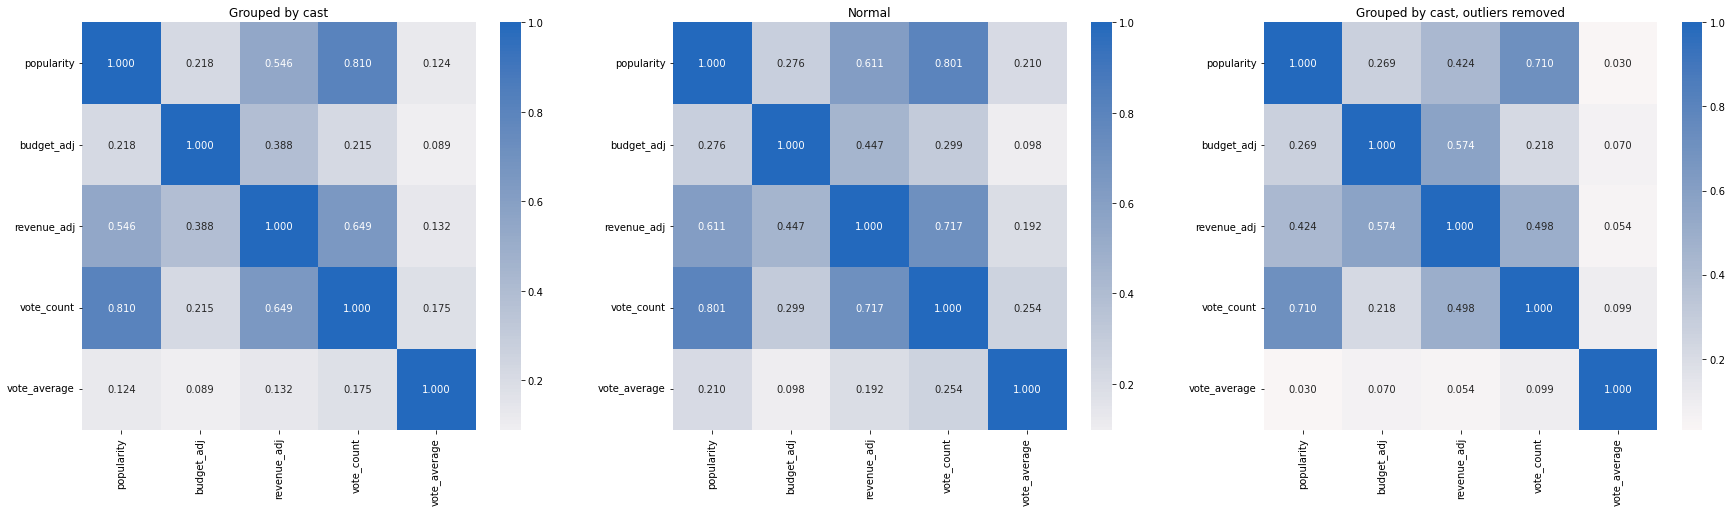

In [43]:
subdf('cast',0.05,0.95)

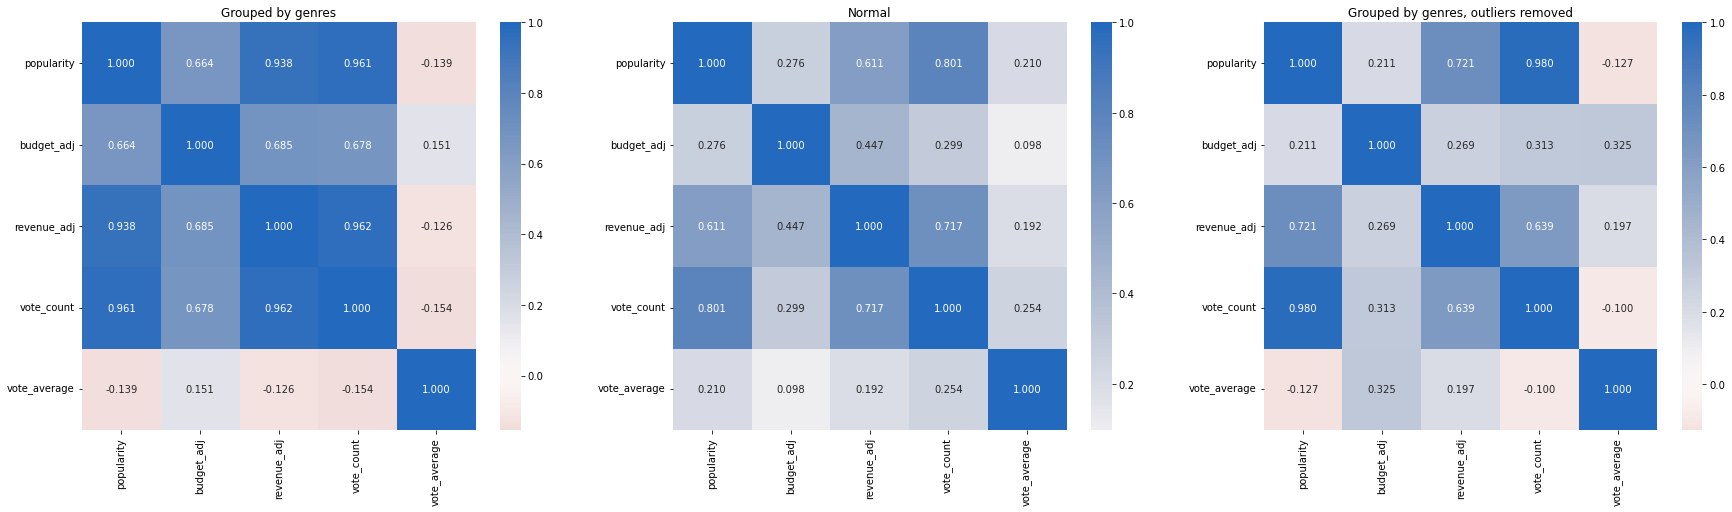

In [44]:
subdf('genres',0.05,0.95)

In [45]:
def plots(column, leftquant, rightquant):
    '''
    Makes a grouped datafram on column specified and calculates it's mean after removing outliers
    for each group and plots pairplot for all features
    
    Arguments:
        column: string that contains name of column
        leftquant: int bet(0-1) of the percentage of removing from left hand side outliers
        rightquant: int bet(0-1) of the percentage of removing from right hand side outliers
        
    Returns:
        void
    '''
    dfs = final[[column, 'popularity', 'budget_adj', 'revenue_adj', 'vote_count', 'vote_average']]
    dfs = dfs[dfs[column].notna()]
    dfs[column] = dfs[column].str.replace('|',',',regex=False).str.strip()
    dfs[column] = dfs[column].str.split(',').tolist()
    dfs = dfs.explode(column,ignore_index=True)
    dfsm = dfs.groupby(column).mean()
    dfsms = dfs.groupby(column).mean()
    
    for i in ['popularity', 'budget_adj', 'revenue_adj', 'vote_count', 'vote_average']:
        pl = dfsms[i].quantile(leftquant)
        pr = dfsms[i].quantile(rightquant)
        dfsms = dfsms[dfsms[i].gt(pl) & dfsms[i].lt(pr)]
    
    g = sns.pairplot(dfsms)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.regplot, line_kws={"color": "black"})
    g.map_offdiag(corrfunc)

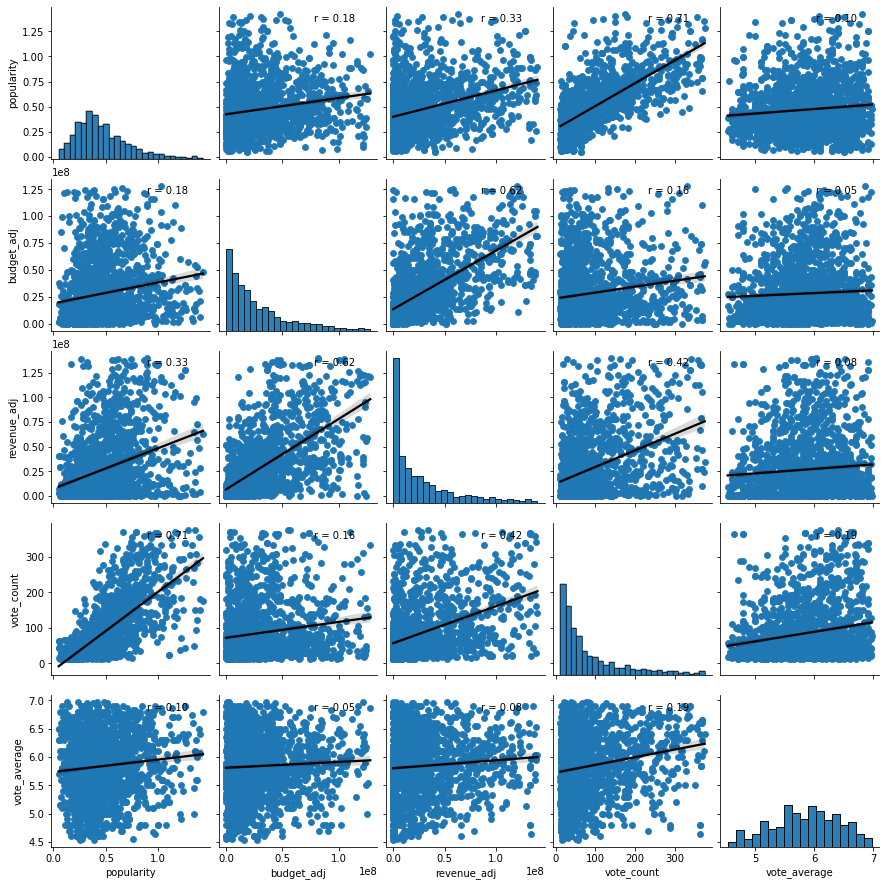

In [46]:
plots('director', 0.05,0.95)

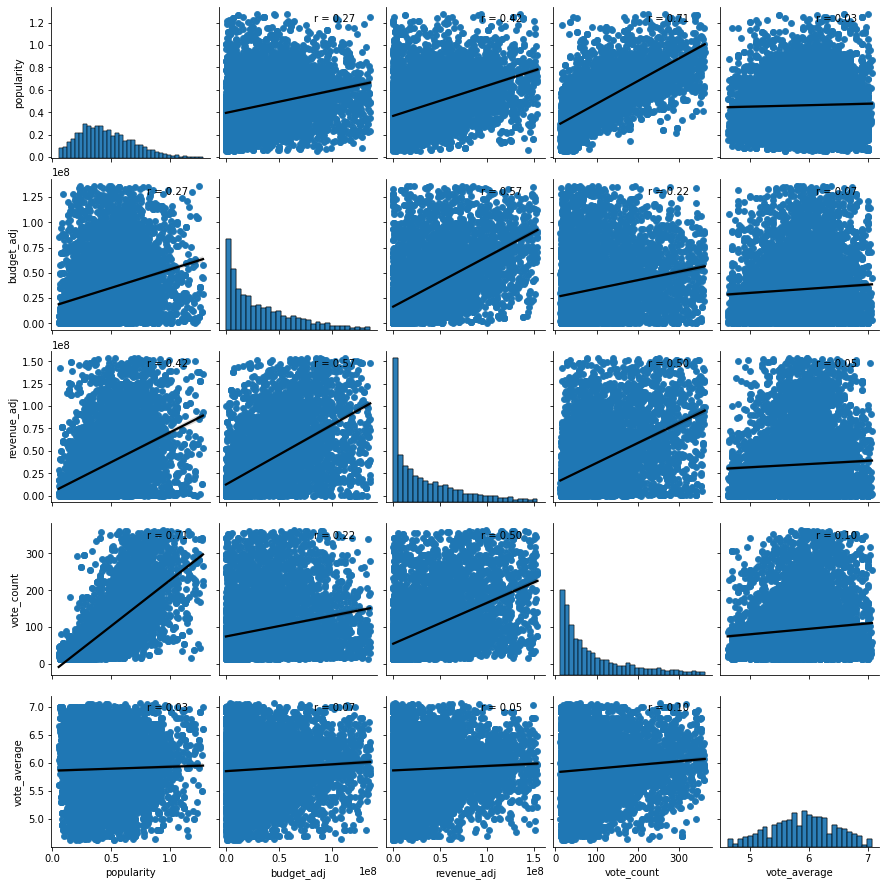

In [47]:
plots('cast', 0.05,0.95)

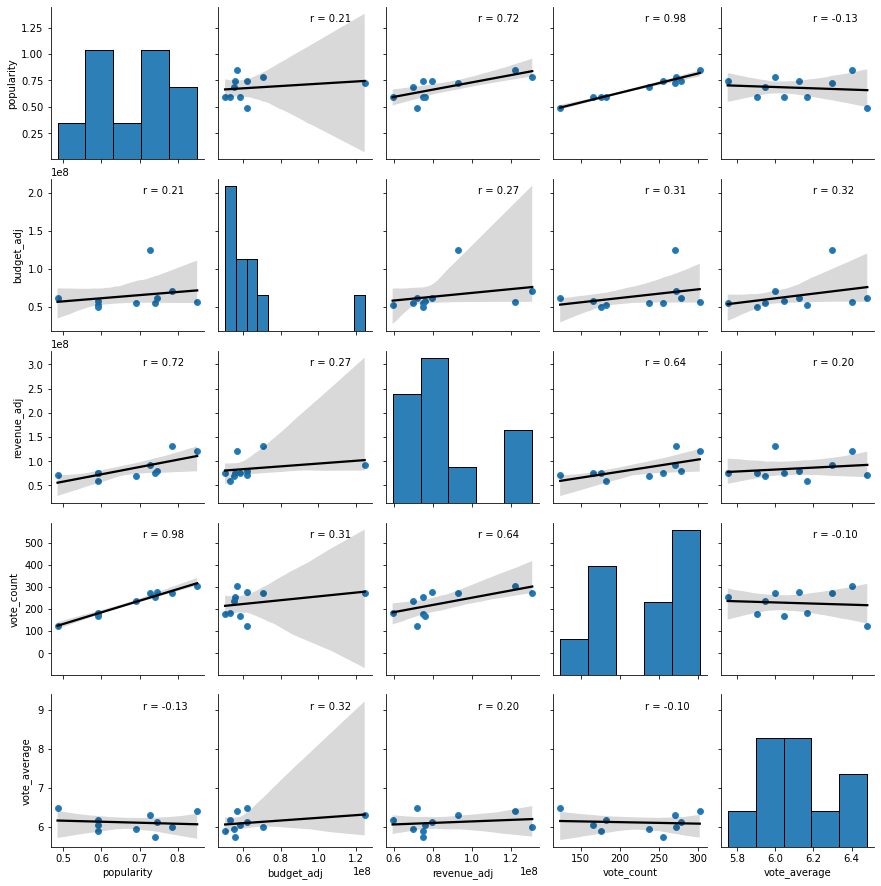

In [48]:
plots('genres', 0.05,0.95)

## Actually there was nothing notable of the grouping which is quiet a bummer however let's summarize up all we have got.

<a id='conclusions'></a>
## Conclusions
> 1.There is a correlation between these columns: [budget, revenue, popularity, vote_count]

> 2.Movie runtime is mostly bound between 90 minutes and 111 with some extreme cases in both directions.

> 3.Seems like the reviews are not audience reviews since the count is so low are the review counts range from 17 and 145 on average.

> 4.The average votes is definitely normally distributed

> 5.Vote_counts play huger role when it comes to revenue than vote_average which is remarkable of how movies that are popular are not the ones that must be critically acclaimed.

> 6.The more popular the movie is the more votes it might get "expected" and more revenue too "expected"

> 7.The higher the vote counts, the higher the average might be.

> 8.The higher times a movie is rated the higher the revenue might gross, however vote average doesn't have such a strong corr and thus we deduce a high grossing movie is a popular movie but that doesn't mean that it's critically acclaimed.

> 9.This will sound good for producers, the more budget you put in the more you revenue.

In [57]:
!jupyter nbconvert --to html Investigate_a_Dataset.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] Writing 2120530 bytes to Investigate_a_Dataset.html
